In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms, utils, models, datasets
from torch.utils.data import Dataset, DataLoader

In [4]:
from synthetic_utils import *

In [5]:
from trainer_dataloader import *
from networks import *
from losses import *

In [6]:
input_size = 96
batch_size = 128
num_workers = 4
num_epochs = 20

In [7]:
cuda = False
pin_memory = False
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    cuda = True
    cudnn.benchmark = True
    pin_memory = True
else:
    device = torch.device("cpu")

print('Device set: {}'.format(device))

Device set: cuda


In [8]:
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((input_size, input_size)),
#             transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
        'val': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
}

In [9]:
# DATA_PATH = '/home/s1791387/diss/gen_shapes/'
DATA_PATH = '/home/var/synthetic_data/dependent_gen/'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
VAL_PATH = os.path.join(DATA_PATH, 'valid')
TEST_PATH = os.path.join(DATA_PATH, 'test')

In [10]:
train_df = datasets.ImageFolder(root=TRAIN_PATH, transform=data_transforms['train'])
val_df = datasets.ImageFolder(root=VAL_PATH, transform=data_transforms['val'])
test_df = datasets.ImageFolder(root=TEST_PATH, transform=data_transforms['val'])

In [11]:
train_loader = DataLoader(train_df, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_df, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_df, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

## Train only encoder first


In [12]:
encoder = LeNet()
classifier = ClassNet()

In [13]:
encoder.to(device)
classifier.to(device)

ClassNet(
  (fc1): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (out_acc): Sigmoid()
)

In [14]:
criterion = nn.BCELoss()
opt_cls = optim.Adam(classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
opt_enc = optim.Adam(encoder.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler_cls = lr_scheduler.StepLR(optimizer=opt_cls, gamma=0.99, step_size=1)
scheduler_enc = lr_scheduler.StepLR(optimizer=opt_enc, gamma=0.99, step_size=1)

In [15]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
        scheduler_cls.step()
        scheduler_enc.step()
        # train
        train_loss, train_acc = train_encoder_classifier_epoch(train_loader, encoder,
                                classifier, opt_enc,
                                opt_cls, criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # validate
        print('-'*10)
        val_loss, val_acc = validate_encoder_classifier_epoch(val_loader, encoder, classifier,
                                 criterion, device)

        print('Avg validation loss: {} \t Accuracy: {}'.format(val_loss, val_acc))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 2.323 (2.323)	Loss 0.7205 (0.7205)	Accuracy 0.4141 (0.4141)
Batch: [10/40]	Time 0.040 (0.467)	Loss 0.6171 (0.6736)	Accuracy 0.6719 (0.5959)
Batch: [20/40]	Time 1.048 (0.441)	Loss 0.5618 (0.6211)	Accuracy 0.7656 (0.6726)
Batch: [30/40]	Time 0.071 (0.400)	Loss 0.4730 (0.5920)	Accuracy 0.7578 (0.6981)
----------


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Test: [0/4]	Time 1.927 (1.927)	Loss 0.5709 (0.5709)	Accuracy 0.7344 (0.7344)
Avg validation loss: 0.507150663137436 	 Accuracy: 0.79
--------------------
Epoch 0/20	Time 17.626 sec (17.626 sec)
--------------------
Epoch: 1/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 1.658 (1.658)	Loss 0.4994 (0.4994)	Accuracy 0.7656 (0.7656)
Batch: [10/40]	Time 0.048 (0.408)	Loss 0.4255 (0.4456)	Accuracy 0.8281 (0.8196)
Batch: [20/40]	Time 1.043 (0.376)	Loss 0.5076 (0.4288)	Accuracy 0.7500 (0.8162)
Batch: [30/40]	Time 0.052 (0.345)	Loss 0.4253 (0.4234)	Accuracy 0.8203 (0.8193)
----------
Test: [0/4]	Time 1.764 (1.764)	Loss 0.5062 (0.5062)	Accuracy 0.7578 (0.7578)
Avg validation loss: 0.4202294108867645 	 Accuracy: 0.824
--------------------
Epoch 1/20	Time 15.381 sec (16.504 sec)
--------------------
Epoch: 2/20
Batch: [0/40]	Time 1.661 (1.661)	Loss 0.3204 (0.3204)	Accuracy 0.8828 (0.8828)
Batch: [10/40]	Time 0.048 (0.389)	Loss 0.3478 (0.3454)	Accuracy 0.8516 (0.8587)
Batch: [20/40]	Time 0.246 (0.337)	Loss 0.3074 (0.3226)	Accuracy 0.9141 (0.8743)
Batch: [30/40]	Time 0.280 (0.337)	Loss 0.2625 (0.3150)	Accuracy 0.8906 (0.8773)
----------
Test: [0/4]	Time 2.551 (2.551)	Loss 0.2694 (0.2694)	Accuracy 0.9375 (0.9375)
Avg validation loss: 0.26919303035

In [16]:
validate_encoder_classifier_epoch(test_loader, encoder, classifier,
                                 criterion, device)

Test: [0/4]	Time 2.616 (2.616)	Loss 0.2628 (0.2628)	Accuracy 0.9766 (0.9766)


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


(0.16127669563889505, 0.976)

In [17]:
import matplotlib.pyplot as plt

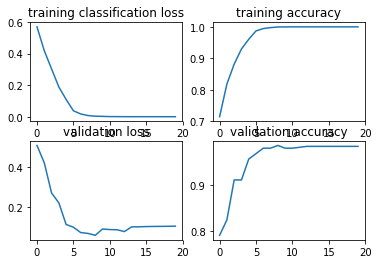

In [18]:
plt.subplot(221)
plt.title('training classification loss')
plt.plot(train_losses)
plt.subplot(222)
plt.title('training accuracy')
plt.plot(train_accs)
plt.subplot(223)
plt.title('validation loss')
plt.plot(val_losses)
plt.subplot(224)
plt.title('validation accuracy')
plt.plot(val_accs)

In [20]:
from synthetic_dataloader import *

In [21]:
gender_train = GenderDataset(train_df)
gender_valid = GenderDataset(val_df)
gender_test = GenderDataset(test_df)

In [22]:
advtrain_loader = DataLoader(gender_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
advval_loader = DataLoader(gender_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
advtest_loader = DataLoader(gender_test, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

In [23]:
encoder = LeNet()
adversary = ClassNet()

In [24]:
encoder.to(device)
adversary.to(device)

ClassNet(
  (fc1): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (out_acc): Sigmoid()
)

In [25]:
criterion = nn.BCELoss()
opt_cls = optim.Adam(classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
opt_enc = optim.Adam(adversary.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler_cls = lr_scheduler.StepLR(optimizer=opt_cls, gamma=0.99, step_size=1)
scheduler_enc = lr_scheduler.StepLR(optimizer=opt_enc, gamma=0.99, step_size=1)

In [26]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
        scheduler_cls.step()
        scheduler_enc.step()
        # train
        train_loss, train_acc = train_encoder_classifier_epoch(advtrain_loader, encoder,
                                adversary, opt_enc,
                                opt_cls, criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # validate
        print('-'*10)
        val_loss, val_acc = validate_encoder_classifier_epoch(advval_loader, encoder, adversary,
                                 criterion, device)

        print('Avg validation loss: {} \t Accuracy: {}'.format(val_loss, val_acc))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 1.828 (1.828)	Loss 0.6996 (0.6996)	Accuracy 0.4141 (0.4141)
Batch: [10/40]	Time 0.062 (0.420)	Loss 0.6913 (0.6927)	Accuracy 0.4922 (0.4922)
Batch: [20/40]	Time 0.790 (0.372)	Loss 0.6868 (0.6912)	Accuracy 0.5625 (0.5056)
Batch: [30/40]	Time 0.067 (0.354)	Loss 0.6895 (0.6904)	Accuracy 0.5078 (0.5129)
----------


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Test: [0/4]	Time 1.887 (1.887)	Loss 0.6796 (0.6796)	Accuracy 0.8672 (0.8672)
Avg validation loss: 0.6834851284027099 	 Accuracy: 0.754
--------------------
Epoch 0/20	Time 15.428 sec (15.428 sec)
--------------------
Epoch: 1/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 1.629 (1.629)	Loss 0.6853 (0.6853)	Accuracy 0.6641 (0.6641)
Batch: [10/40]	Time 0.059 (0.420)	Loss 0.6818 (0.6833)	Accuracy 0.7500 (0.7443)
Batch: [20/40]	Time 0.456 (0.358)	Loss 0.6749 (0.6813)	Accuracy 0.7969 (0.7571)
Batch: [30/40]	Time 0.317 (0.346)	Loss 0.6753 (0.6796)	Accuracy 0.7188 (0.7578)
----------
Test: [0/4]	Time 1.793 (1.793)	Loss 0.6831 (0.6831)	Accuracy 0.6172 (0.6172)
Avg validation loss: 0.6717818779945374 	 Accuracy: 0.716
--------------------
Epoch 1/20	Time 15.081 sec (15.255 sec)
--------------------
Epoch: 2/20
Batch: [0/40]	Time 1.746 (1.746)	Loss 0.6735 (0.6735)	Accuracy 0.6953 (0.6953)
Batch: [10/40]	Time 0.046 (0.418)	Loss 0.6611 (0.6697)	Accuracy 0.7656 (0.7209)
Batch: [20/40]	Time 0.807 (0.380)	Loss 0.6707 (0.6675)	Accuracy 0.6719 (0.7329)
Batch: [30/40]	Time 0.214 (0.357)	Loss 0.6621 (0.6664)	Accuracy 0.7578 (0.7286)
----------
Test: [0/4]	Time 1.691 (1.691)	Loss 0.6700 (0.6700)	Accuracy 0.6719 (0.6719)
Avg validation loss: 0.65595634126

In [27]:
validate_encoder_classifier_epoch(advtest_loader, encoder, adversary, criterion, device)

Test: [0/4]	Time 1.526 (1.526)	Loss 0.3130 (0.3130)	Accuracy 0.9141 (0.9141)


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


(0.3632740023136139, 0.872)

In [28]:
import matplotlib.pyplot as plt

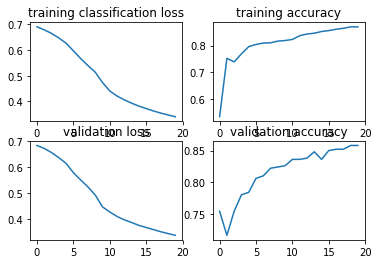

In [29]:
plt.subplot(221)
plt.title('training classification loss')
plt.plot(train_losses)
plt.subplot(222)
plt.title('training accuracy')
plt.plot(train_accs)
plt.subplot(223)
plt.title('validation loss')
plt.plot(val_losses)
plt.subplot(224)
plt.title('validation accuracy')
plt.plot(val_accs)